<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Setup
Let's begin by installing and importing the modules we'll need.

In [5]:
#!pip install -q --upgrade pyro-ppl torch
import pyro
import torch
import pyro.distributions as dist

assert pyro.__version__.startswith('1.8.1')

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Icecream Shop

In this self study session, you will be modeling the sales in an ice cream shop. Below you will find an initial specification, and in the following sections you should elaborate on this initial specificaton.

The basis for our model is that 
* We **record the ice-cream sales and the average temperature of the day** (using a temperature sensor).

* We know **temperature affects the sales** of ice-creams.

* We want to **precisely model** how temperature affects ice-cream sales.

<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/Ice-cream_shop_-_Florida.jpg" alt="Drawing" width=300 >
</center>

Note that the model given below is a extension of the temperature model that we explored during the last lecture.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


## Model specification

* We have **observations** from temperature and sales:
>- The relation between the daily temperature $t_i$ and the measured temperature $s_{t,i}$ will be modeled with a Normal distribution as in the last lecture. 
* Daily sales $s_i$ are modeled with a <a href="https://en.wikipedia.org/wiki/Poisson_distribution">Poisson distribution</a>, which expresses the probability of a given number of sales per day based on a so-called rate parameter (the mean and variance of the Poisson distribution is also equal to the rate parameeter):
>- We assume that the rate of the Poisson distribution **linearly depends of the real temperature**.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model.png?raw=1" alt="Drawing" width=700>
</center>



### Data

In [6]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.])}

### Pyro specification of the ice-cream model

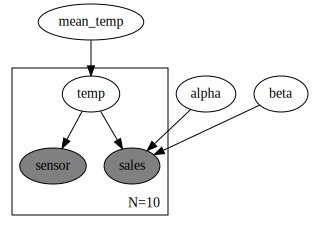

In [9]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))

    with pyro.plate('N='+str(obs['sensor'].shape[0]), obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

#Visualize the model
pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### Auxiliary function

In [11]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoNormal


def svi(model, obs, guide=None, num_steps = 500, plot = False, verbose=False, lr=0.01):
    
    torch.manual_seed(999)

    pyro.clear_param_store()
    
    if guide is None:
        guide = AutoNormal(model)
    
    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         optim=SGD({"lr": lr, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []
    
    for t in range(num_steps):
        losses.append(svi.step(obs))
        if t%100==0:
            print('Step: '+str(t)+'. Loss: ' +str(losses[-1]))
            

    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()
        
    if verbose:
        print("Inference results:")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name))

## Learning and inference

Let's take our model out for a test run

In [12]:
#Run inference
svi(model, obs, num_steps = 3000, lr = 0.001)

#Print results    
print("Posterior temperature mean")
print(dist.Normal(pyro.param("AutoNormal.locs.mean_temp").item(), pyro.param("AutoNormal.scales.mean_temp").item()))
print("")
print("Posterior alpha")
print(dist.Normal(pyro.param("AutoNormal.locs.alpha").item(), pyro.param("AutoNormal.scales.alpha").item()))
print("")
print("Posterior beta")
print(dist.Normal(pyro.param("AutoNormal.locs.beta").item(), pyro.param("AutoNormal.scales.beta").item()))


Step: 0. Loss: 6918.239551782608
Step: 100. Loss: 1706.8237700462341
Step: 200. Loss: 1406.938106417656
Step: 300. Loss: 1167.6916875839233
Step: 400. Loss: 969.2326369285583
Step: 500. Loss: 804.8422137498856
Step: 600. Loss: 669.4960304498672
Step: 700. Loss: 560.7487533092499
Step: 800. Loss: 474.4860633611679
Step: 900. Loss: 392.1057023406029
Step: 1000. Loss: 340.65725284814835
Step: 1100. Loss: 280.30738401412964
Step: 1200. Loss: 257.1042993068695
Step: 1300. Loss: 207.26777589321136
Step: 1400. Loss: 189.91828846931458
Step: 1500. Loss: 164.5289467573166
Step: 1600. Loss: 154.52784037590027
Step: 1700. Loss: 126.25967526435852
Step: 1800. Loss: 117.71682906150818
Step: 1900. Loss: 112.76161724328995
Step: 2000. Loss: 100.08542639017105
Step: 2100. Loss: 98.10370969772339
Step: 2200. Loss: 92.16431868076324
Step: 2300. Loss: 80.70335939526558
Step: 2400. Loss: 79.52297711372375
Step: 2500. Loss: 71.627081990242
Step: 2600. Loss: 76.57995247840881
Step: 2700. Loss: 68.3530302047

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 1: Analyze the model above </span> 
* Consider the model specification together with the posterior distributions over the model parameters. Do the these distributions appear reasonabale to you considering the model and the data that you have supplied?

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 2: Introduce Humidity in the Icecream shop model </span> 

In this exercise you should extend the model above to also account for the daily humidity $h_i$:
* Assume we also have a bunch of daily humidity sensor measurements $s_{h,i}$.
* Assume the **sales are also linearly influenced by the humidity**.

Extend the model above in order to integrate these new pieces of information.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model-Humidity.png?raw=1" alt="Drawing" width=1000>
</center>




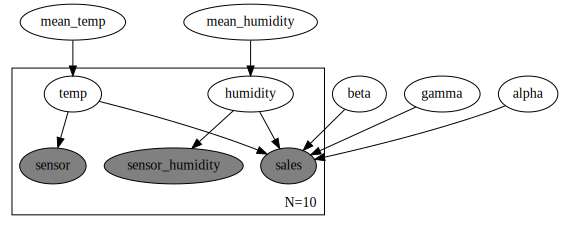

In [13]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random variable "mean_humidity"
    mean_humidity = ...

    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    
    ## Introduce a coefficient for the humidity "gamma"
    gamma = ...

    with pyro.plate('N='+str(obs['sensor'].shape[0]), obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        #Add the 'humidity' variable and the 'sensor_humidity' variable
        humidity = ...
        sensor_humidity = ...
        #Add the linear dependency for the rate with respect to temp and humidity (keep torch.max to avoid numerical stability issues)
        rate = torch.max(torch.tensor(0.001), alpha + ???)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

#Visualize the model
pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we rely on the **(variational) inference engine** to get the results.

In [15]:
#Run inference
svi(model, obs, num_steps=3000, lr=0.001)

#Print results    
print("Posterior temperature mean")
print(dist.Normal(pyro.param("AutoNormal.locs.mean_temp").item(), pyro.param("AutoNormal.scales.mean_temp").item()))
print("")
print("Posterior Humidity Mean")
print(dist.Normal(pyro.param("AutoNormal.locs.mean_humidity").item(), pyro.param("AutoNormal.scales.mean_humidity").item()))
print("")
print("Posterior alpha")
print(dist.Normal(pyro.param("AutoNormal.locs.alpha").item(), pyro.param("AutoNormal.scales.alpha").item()))
print("")
print("Posterior beta")
print(dist.Normal(pyro.param("AutoNormal.locs.beta").item(), pyro.param("AutoNormal.scales.beta").item()))
print("")
print("Posterior Gamma")
print(dist.Normal(pyro.param("AutoNormal.locs.gamma").item(), pyro.param("AutoNormal.scales.gamma").item()))


Step: 0. Loss: 43415.62390244007
Step: 100. Loss: 32385.001664161682
Step: 200. Loss: 26350.05538070202
Step: 300. Loss: 21488.486005723476
Step: 400. Loss: 17607.42182946205
Step: 500. Loss: 14453.095434904099
Step: 600. Loss: 11926.5579829216
Step: 700. Loss: 9850.370540440083
Step: 800. Loss: 8091.017843008041
Step: 900. Loss: 6682.5813729166985
Step: 1000. Loss: 5537.7136870622635
Step: 1100. Loss: 4582.031100511551
Step: 1200. Loss: 3812.805585503578
Step: 1300. Loss: 3114.9971845149994
Step: 1400. Loss: 2678.093333542347
Step: 1500. Loss: 2197.645199239254
Step: 1600. Loss: 1855.6751796603203
Step: 1700. Loss: 1547.3148487210274
Step: 1800. Loss: 1284.7618195414543
Step: 1900. Loss: 1079.2135246992111
Step: 2000. Loss: 926.1471285820007
Step: 2100. Loss: 821.3309555649757
Step: 2200. Loss: 681.423729121685
Step: 2300. Loss: 590.1314957737923
Step: 2400. Loss: 532.230705499649
Step: 2500. Loss: 449.05122858285904
Step: 2600. Loss: 413.5098954439163
Step: 2700. Loss: 381.9173864126

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# 5.  **Temporal Models**

If we expect that there might a temporal dependency between the variables, we can capture this in the model specification.

Let us assume that there is a **temporal dependency** between the variables.

* E.g. the current real temperature must be similar to the real temperature in the previous time step.

This temporal dependency can be modeled using a **for-loop** in Pyro as illustrated in the graphical representation.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/tempmodel-temporal-III.png" alt="Drawing" style="width: 350px;" >

Observe how this temporal model shares commonalities with the temporal models that we discussed a couple of lectures a go. 

In [16]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        prev_temp = temp

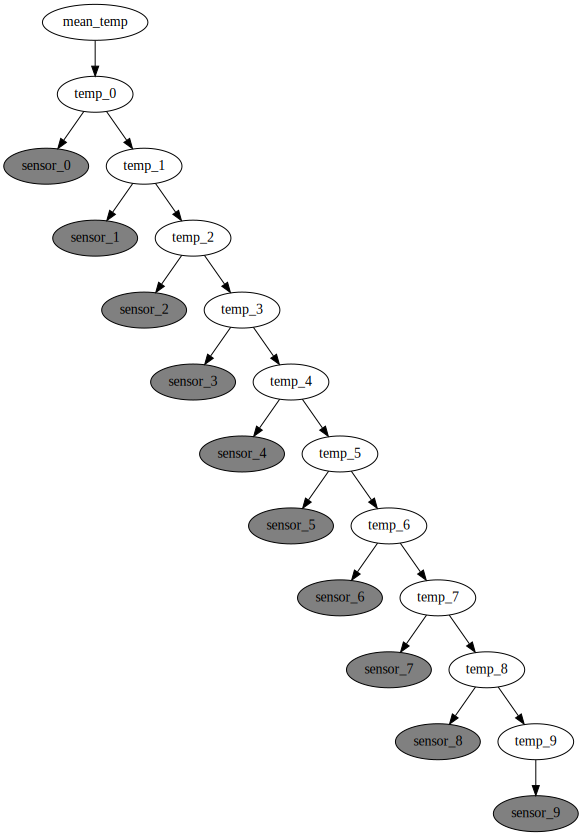

In [17]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we rely on the **(variational) inference engine** to get the results.

In [34]:
import time
        
#Run inference
svi(model, obs)

smooth_temp=[]
for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f"AutoNormal.locs.temp_{i}").item())

print('Finished')

Step: 0. Loss: 2015.5972937345505
Step: 100. Loss: 267.1859998703003
Step: 200. Loss: 58.00642013549805
Step: 300. Loss: 28.139065474271774
Step: 400. Loss: 22.716069281101227
Finished


We can now plot the **observered measurements** of the temperature **against** the inferred **real temperature**.

* By querying the **local hidden** we can **smooth** the temperature.

* The **recovered temperature** is much less noisy than the measured one. 

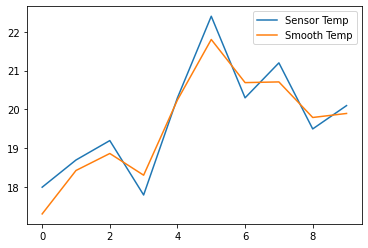

In [35]:
import matplotlib.pyplot as plt
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

### <span style="color:red">Exercise 3:  Temporal Extension of the Iceacream shop model </span> 

Assume that:
* temperature depends of the **temperature in the previous day**.
* humidity depends of the **humidity in the previous day**.
* sales depends on the **current temperature and humidity**.

Use the following **graphical representation for reference**.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/icecream-model-temporal.png" alt="Drawing" width=800 >

Note that the plate representation has to be coded in Pyro using a **``for-loop``**.

In [36]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}



def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random variable "mean_humidity"
    mean_humidity = ...


    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    ## Introduce a coefficient for the humidity "gamma"
    gamma = ...

    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
            #Introduce the 'humidity' variable at time 0.
            humidity = ...
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
            #Introduce the f'humidity_{i}' variable defining the transition
            humidity = ...
            
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        #Introduce the f'sensor_humidity_{i}' variable. 
        sensor_humidity = ...
        
        #Add the linear dependency for the rate with respect to temp and humidity (keep torch.max to avoid numerical stability issues)
        rate = ...
        sales = pyro.sample(f'sales_{i}', dist.Poisson(rate), obs=obs['sales'][i])

        prev_temp = temp
        #Keep humidity for the next time step. 
        prev_humidity = humidity

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


Again we need a guide for performing inference (you need not worry about the details of this part)

In [39]:
import time
        
#Run inference
svi(model, obs, num_steps=1000)

smooth_temp=[]
smooth_humidity=[]

for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f'AutoNormal.locs.temp_{i}').item())
    smooth_humidity.append(pyro.param(f'AutoNormal.locs.humidity_{i}').item())

print('Finished')

Step: 0. Loss: 43268.54707288742
Step: 100. Loss: 9498.411389827728
Step: 200. Loss: 4919.906882464886
Step: 300. Loss: 4310.815666496754
Step: 400. Loss: 4225.197531938553
Step: 500. Loss: 4203.451551795006
Step: 600. Loss: 4185.5067256093025
Step: 700. Loss: 4191.160065472126
Step: 800. Loss: 4186.763629734516
Step: 900. Loss: 4185.192358911037
Finished


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we can plot the observered measurements of the temperature against the **inferred real temperature** by our model. The **recovered temperature** is much less noisy than the real one.

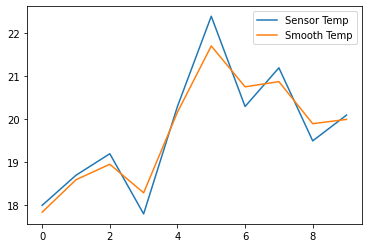

In [40]:
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()

We can also plot the observered measurements of the humidity against the **inferred real humidity** by our model. The **recovered humidity** is much less noisy than the real one.

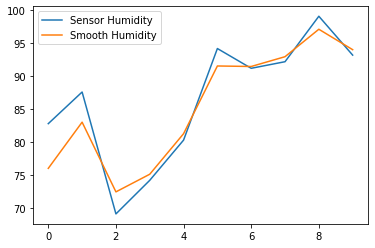

In [41]:
humidity = torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])
plt.plot(humidity.detach().numpy(), label='Sensor Humidity')
plt.plot(smooth_humidity, label='Smooth Humidity')
plt.legend()

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>
